<a href="https://colab.research.google.com/github/JackieVeatch/GCC_2025_PythonWorkshop/blob/main/GCC_SatelliteWorkbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Welcome to the Satellite (3D data) breakout group!
Jacquelyn Veatch, November 8th 2025 <br> <br>
In this notebook, we will load in Satellite data from MODIS-A. This code will build upon what we learned in "GCC_PythonReview.ipynb", and then explore more data visualization and statistical methods in common Python packages! <br> <br>

The MODIS-A (Moderate Resolution Imaging Spectroradiometer aboard NASA’s Aqua satellite) is an Earth-observing instrument launched in 2002 as part of the Aqua mission in NASA’s Earth Observing System. It measures reflected and emitted radiation in 36 spectral bands to monitor global ocean color, land surface changes, atmospheric properties, and sea surface temperature with near-daily coverage. In this notebook, we will work with ocean color data, which is used as a proxy for Chlorophyll-A biomass (phytoplankton abundance) https://modis.gsfc.nasa.gov/about/

In [3]:
# it is considered best practice to include all imports at the top of your code
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import xarray as xr

In [4]:
# load data using xarray, which is a library that handles 3D data arrays well

# This is a path to where this text file is stored on my GitHub
url = 'https://raw.githubusercontent.com/JackieVeatch/GCC_2025_PythonWorkshop/main/chl_8day_4km_SUBSET_first3.nc'
## Load the text file with the loadtxt() function from numpy
MODISA = xr.open_dataset(url)
MODISA

<xarray.Dataset> Size: 222kB
Dimensions:  (time: 3, lat: 96, lon: 192)
Coordinates:
  * time     (time) datetime64[ns] 24B 2024-06-05T02:02:30 ... 2024-06-21T01:...
  * lat      (lat) float32 384B 67.98 67.94 67.9 67.85 ... 64.1 64.06 64.02
  * lon      (lon) float32 768B -172.0 -171.9 -171.9 ... -164.1 -164.1 -164.0
Data variables:
    chlor_a  (time, lat, lon) float32 221kB ...
Attributes:
    title:        MODIS-Aqua L3m 8-day chlor_a (spatial subset; first two tim...
    history:      Created 2025-11-06T05:09:08.714817Z in Jupyter
    source:       NASA OBPG MODIS-Aqua L3m 8-day (4 km) chlor_a
    conventions:  CF-1.8
    note:         chlor_a is NaN where original _FillValue was present; spati...

Above, Xarray should have printed the header of your dataset. Take a minute to read this informtion. What are the coordinates? What are the variables? What is the shape of these data? <br>

Check Point: can you draw (or described) the shape of this array?

In [9]:
MODISA['chlor_a'].shape

(3, 96, 192)

Let's index our data for just the first timestep. Included in these data are 3, 8-day composites, meaning that the first timestep is an 8-day average of ocean color measurements in the region.

In [11]:
first_timestep = MODISA.isel(time=0)
first_timestep

<xarray.Dataset> Size: 75kB
Dimensions:  (lat: 96, lon: 192)
Coordinates:
  * lat      (lat) float32 384B 67.98 67.94 67.9 67.85 ... 64.1 64.06 64.02
  * lon      (lon) float32 768B -172.0 -171.9 -171.9 ... -164.1 -164.1 -164.0
    time     datetime64[ns] 8B 2024-06-05T02:02:30
Data variables:
    chlor_a  (lat, lon) float32 74kB ...
Attributes:
    title:        MODIS-Aqua L3m 8-day chlor_a (spatial subset; first two tim...
    history:      Created 2025-11-06T05:09:08.714817Z in Jupyter
    source:       NASA OBPG MODIS-Aqua L3m 8-day (4 km) chlor_a
    conventions:  CF-1.8
    note:         chlor_a is NaN where original _FillValue was present; spati...

In [12]:
first_timestep['chlor_a'].shape

(96, 192)

Now we have a 2D array, representing chlorophyll-a data for one timestamp (one, 8-day composite) <br>
Let's visualize these data spatially, as if looking as a map

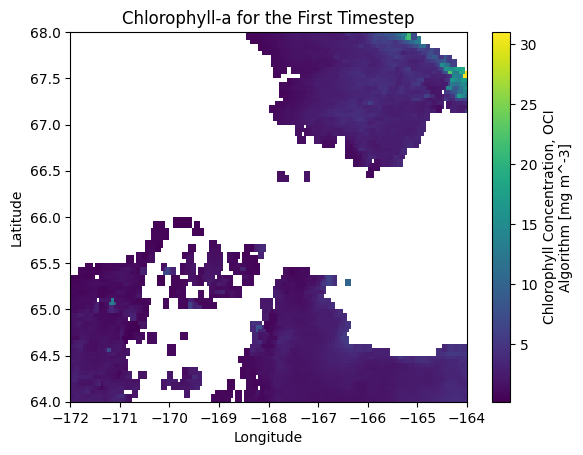

In [13]:
first_timestep['chlor_a'].plot()
plt.title('Chlorophyll-a for the First Timestep')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

That's a lot of missing data! This is to be expected. Ocean color cannot be observed through clouds, so everywhere where there are clouds, not data are observed. There is also no data on land. Let's try the next day and add the coastline so we know where data is missing becuase of cloud coverage and where data is missing because there is land. <br>

To add coastlines, we will have to install a pyton package that is not already on Google Colab. Run the cell below just once, it may take a little longer than other cells.

In [31]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 67.1 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_rivers_lake_centerlines.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


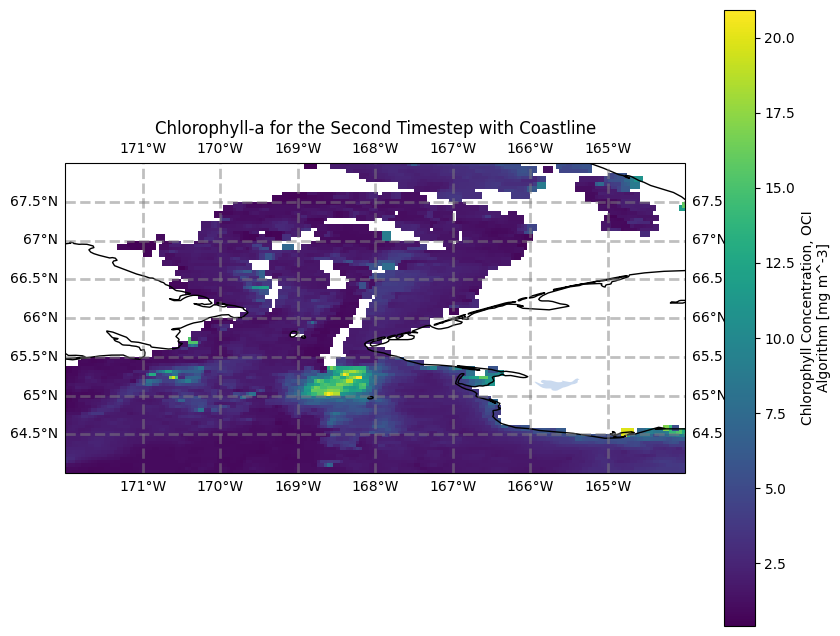

In [32]:
# now we need to import our new package into our working environment
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# and now we can use cartopy to add the coastlines!

second_timestep = MODISA.isel(time=1)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

second_timestep['chlor_a'].plot(ax=ax, transform=ccrs.PlateCarree(), x='lon', y='lat')

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
ax.gridlines(draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')

plt.title('Chlorophyll-a for the Second Timestep with Coastline')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

It looks like a lot of the "missing" data is over land, but we also have a bit of clouds here... what if we took the average of each of these three timestamps?

In [16]:
average_chlor_a = MODISA['chlor_a'].mean(dim='time')
average_chlor_a

<xarray.DataArray 'chlor_a' (lat: 96, lon: 192)> Size: 74kB
array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [1.4959849, 1.481435 , 1.4437424, ..., 3.5548735, 3.6379106,
        3.7009351],
       [1.1562222, 1.1538574, 1.2888924, ..., 3.7463388, 3.7158499,
        3.7158554],
       [1.2834793, 1.2834793, 1.2944704, ..., 3.9109347, 3.9019697,
        3.8475933]], dtype=float32)
Coordinates:
  * lat      (lat) float32 384B 67.98 67.94 67.9 67.85 ... 64.1 64.06 64.02
  * lon      (lon) float32 768B -172.0 -171.9 -171.9 ... -164.1 -164.1 -164.0

Note: using MODISA['chlor_a'].mean(dim='time') already handles NaN values by default. The mean() function in xarray automatically ignores NaN values when calculating the mean along a specified dimension. <br>

So, the average_chlor_a you calculated is the mean of only the non-NaN values across the three timesteps for each spatial location. <br>

NaN stands for "not a number" and is a placeholder when no data exist.

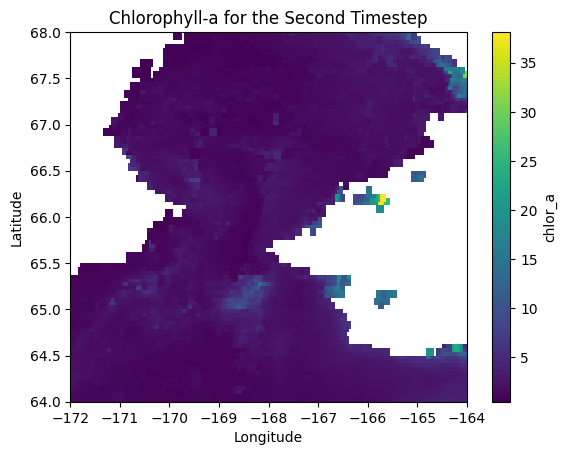

In [17]:
average_chlor_a.plot()
plt.title('Chlorophyll-a for the Second Timestep')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Alright, we have some more information now! But it looks like we have a few datapoints that are really high and a bunch that are low. To be sure of this, lets plot a histogram of all of our `chlor_a` averaged values.

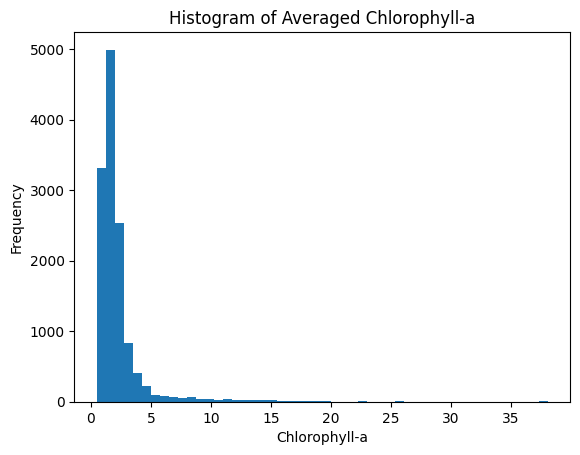

In [18]:
plt.hist(average_chlor_a.values.flatten(), bins=50)
plt.title('Histogram of Averaged Chlorophyll-a')
plt.xlabel('Chlorophyll-a')
plt.ylabel('Frequency')
plt.show()

Our suspisions were correct, we have a lot of low numbers. To visualize these data better, lets take the log of the data.

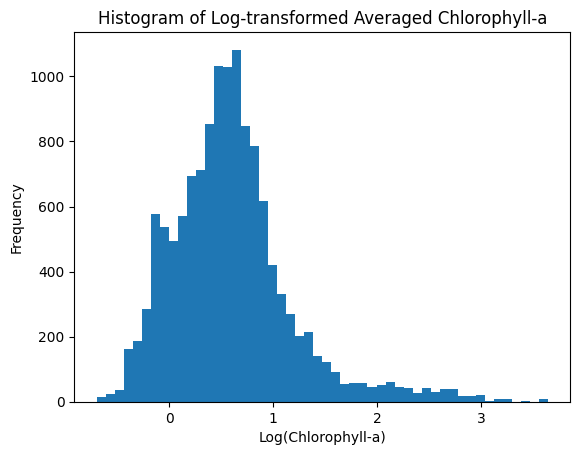

In [19]:
log_average_chlor_a = np.log(average_chlor_a)

plt.hist(log_average_chlor_a.values.flatten(), bins=50)
plt.title('Histogram of Log-transformed Averaged Chlorophyll-a')
plt.xlabel('Log(Chlorophyll-a)')
plt.ylabel('Frequency')
plt.show()

Aaahhh, this is closer to gausian. Lets use the log of `average_chlor_a` in our spatial map as well.

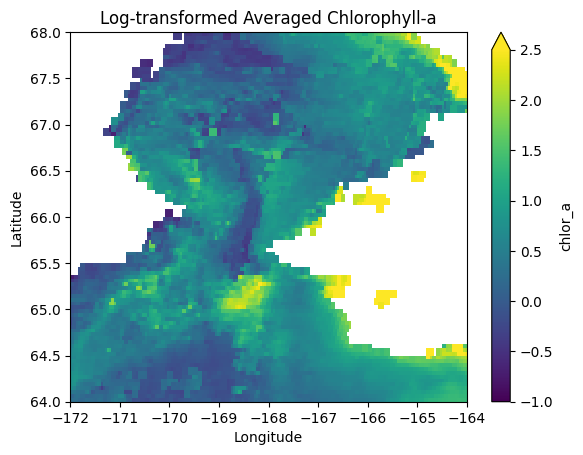

In [22]:
log_average_chlor_a.plot(cmap='viridis', vmin=-1, vmax=2.5)
plt.title('Log-transformed Averaged Chlorophyll-a')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

We get a lot more information from this plot! <br>

Xarray dataset also have some built in statistical functions that can help us learn more about our data.

In [25]:
print("Mean:", MODISA['chlor_a'].mean().values)
print("Standard Deviation:", MODISA['chlor_a'].std().values)
print("Minimum:", MODISA['chlor_a'].min().values)
print("Maximum:", MODISA['chlor_a'].max().values)

Mean: 2.196808338165283
Standard Deviation: 2.4201135635375977
Minimum: 0.18728293478488922
Maximum: 49.9426155090332


And there are even more statistical tools we can use in the `stats` library that we imported from `scipy` in our first cell of this workbook.

In [29]:
# Flatten the array and remove NaN values before calculating statistics
chlor_a_flat = MODISA['chlor_a'].values.flatten()
chlor_a_flat = chlor_a_flat[~np.isnan(chlor_a_flat)]

print("Original array has shape", MODISA['chlor_a'].shape)
print("Flattened array has shape", chlor_a_flat.shape)

print("IQR:", stats.iqr(chlor_a_flat))
print("Skewness:", stats.skew(chlor_a_flat))
print("Kurtosis:", stats.kurtosis(chlor_a_flat))

Original array has shape (3, 96, 192)
Flattened array has shape (29936,)
IQR: 1.4811269044876099
Skewness: 6.418751
Kurtosis: 72.08111


### Try it on your own
(1) add coastlines to the plot of `log_average_chlor_a`. Bonus challenger: make the projection of the map better (becuase we are so far north, the curvature of the Earth is bigger than closer to the equator) <br>
(2) Plot a historgram of values for each day of data. First, you will need to index the dataset for each day, and then second plot the data one dat at a time. <br>
(3) Challenge: Calculate the total coverage of data for each of the three timesteps. How many gridpoints have good data for each day?